In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


Performed customer segmentation analysis on an e-commerce retailer's transactional 

use K-Means clustering to conduct RFM (Recency, Frequency, Monetary Value) analysis, segmenting the customer base into distinct groups based on the purchasing behavior of different products and goods


* Cluster 0: Mostly home goods, some media. Recent buyers, low purchase frequency, moderate spending.
* Cluster 1: Similar to Cluster 0, but purchases are less recent.
* Cluster 2: Fewer home goods, no media. Moderate purchase recency, slightly higher frequency, high spending.
* Cluster 3: Many home goods, fewer media. Moderate purchase recency, high frequency, higher spending but less than Cluster 2.

Utilized ARIMA (Autoregressive Integrated Moving Average) modeling to forecast future online sales trends, accurately predicting a gradual increase in e-commerce sales during the upcoming holiday season

In [2]:
customers_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv') 
order_items_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
orders_df = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv') 
orders_product = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv') 
payment = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
sell = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')

In [3]:
print("customers_df")
customers_df.info()
print("\n")  # Print a newline for separation

print("order_items_df")
order_items_df.info()
print("\n")

print("orders_df")
orders_df.info()
print("\n")

print("orders_product")
orders_product.info()
print("\n")

print("payment")
payment.info()
print("\n")

print("sell")
sell.info()
print("\n")

customers_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


order_items_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limi

In [4]:
# 1. Join orders and order items
orders_items_df = orders_df.merge(order_items_df, on='order_id', how='inner')

# 2. Join with customers
orders_items_customers_df = orders_items_df.merge(customers_df, on='customer_id', how='inner')

fin = orders_items_customers_df.merge(orders_product, on='product_id', how='inner')

pay = fin.merge(payment, on='order_id', how='inner')



In [5]:
list_item = []
for col in pay.columns:
    list_item.append([col, pay[col].dtype, pay[col].isna().sum(), 100*pay[col].isna().sum()/len(pay[col]), pay[col].nunique(), pay[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,order_id,object,0,0.000000,98665,"[e481f51cbdc54678b7cc49136f2d6af7, 53cdb2fc8bc..."
1,customer_id,object,0,0.000000,98665,"[9ef432eb6251297304e76186b10a928d, b0830fb4747..."
2,order_status,object,0,0.000000,7,"[delivered, invoiced, shipped, processing]"
3,order_purchase_timestamp,object,0,0.000000,98111,"[2017-10-02 10:56:33, 2018-07-24 20:41:37, 201..."
4,order_approved_at,object,15,0.012755,90173,"[2017-10-02 11:07:15, 2018-07-26 03:24:27, 201..."
5,order_delivered_carrier_date,object,1245,1.058664,81016,"[2017-10-04 19:55:00, 2018-07-26 14:31:00, 201..."
6,order_delivered_customer_date,object,2567,2.182805,95663,"[2017-10-10 21:25:13, 2018-08-07 15:27:45, 201..."
7,order_estimated_delivery_date,object,0,0.000000,449,"[2017-10-18 00:00:00, 2018-08-13 00:00:00, 201..."
8,order_item_id,int64,0,0.000000,21,"[1, 2, 3, 4]"
9,product_id,object,0,0.000000,32951,"[87285b34884572647811a353c7ac498a, 595fac2a385..."


In [6]:
df = pay
df = df.dropna()

In [7]:


# Convert the 'order_delivered_customer_date' column to datetime
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Convert the 'order_delivered_customer_date' column to 'yy/mm/dd' format
df['order_delivered_customer_date_str'] = df['order_delivered_customer_date'].dt.strftime('%y/%m/%d')

# Find the maximum date in the 'order_delivered_customer_date' column
max_date = df['order_delivered_customer_date'].max()

# Calculate the recency by subtracting the order_delivered_customer_date from the maximum date
df['recency'] = (max_date - df['order_delivered_customer_date']).dt.days

# Group the data by customer_unique_id and calculate the minimum recency for each customer
recency_by_customer = df.groupby('customer_unique_id')['recency'].min().reset_index()

# Print the recency_by_customer DataFrame
recency_by_customer.head(10)

/tmp/ipykernel_18/1484280759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
/tmp/ipykernel_18/1484280759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_delivered_customer_date_str'] = df['order_delivered_customer_date'].dt.strftime('%y/%m/%d')
/tmp/ipykernel_18/1484280759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,153
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159
2,0000f46a3911fa3c0805444483337064,559
3,0000f6ccb0745a6a4b88665a16c9f078,349
4,0004aac84e0df4da2b147fca70cf8255,323
5,0004bd2a26a76fe21f786e4fbd80607f,192
6,00050ab1314c0e55a6ca13cf7181fecf,173
7,00053a61a98854899e70ed204dd4bafe,214
8,0005e1862207bf6ccc02e4228effd9a0,587
9,0005ef4cd20d2893f0d9fbd94d3c0d97,165


In [8]:
# Create the 'rfm' table
rfm = recency_by_customer.copy()

# Count the number of unique order_id for each customer_unique_id to get the frequency
frequency = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
frequency.columns = ['customer_unique_id', 'frequency']

# Merge the 'rfm' table with the 'frequency' DataFrame
rfm = rfm.merge(frequency, on='customer_unique_id', how='left')

# Print the 'rfm' table


Cohort 

order_approved_at be cohort

In [9]:
# Sum the 'payment_value' for each customer_unique_id to get the monetary value
monetary_value = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()
monetary_value.columns = ['customer_unique_id', 'monetary_value']

# Merge the 'rfm' table with the 'monetary_value' DataFrame
rfm = rfm.merge(monetary_value, on='customer_unique_id', how='left')

# Print the 'rfm' table
rfm.head(5)

,customer_unique_id,recency,frequency,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,153,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159,1,27.19
2,0000f46a3911fa3c0805444483337064,559,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,349,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,323,1,196.89


In [10]:
rfm.describe()

,recency,frequency,monetary_value
count,92081.000000,92081.000000,92081.000000
mean,272.419978,1.033090,212.101338
std,151.948668,0.206859,643.626746
min,0.000000,1.000000,9.590000
25%,152.000000,1.000000,63.830000
50%,252.000000,1.000000,112.820000
75%,382.000000,1.000000,202.150000
max,735.000000,14.000000,109312.640000


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

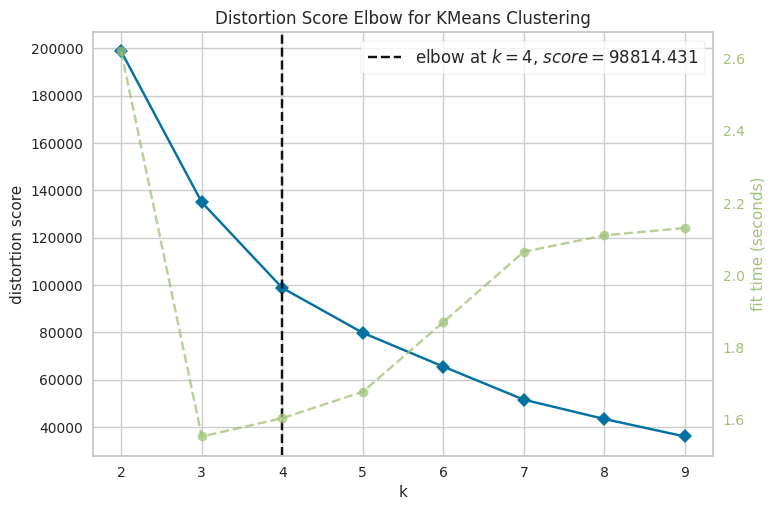

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler

numeric_features = rfm[['recency', 'frequency', 'monetary_value']]

# Instantiate and fit the StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

km_model = KMeans()

# Instantiate the visualizer
visualizer = KElbowVisualizer(km_model, k=(2, 10))

# Fit the visualizer to the RFM data
visualizer.fit(scaled_features)

# Display the visualizer
visualizer.show()

In [12]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Inverse transform the scaled features to get the original, raw values
original_features = scaler.inverse_transform(scaled_features)

# Create a new DataFrame with the original features, cluster assignments, and customer IDs
rfm_with_clusters = rfm[['customer_unique_id']].copy()
rfm_with_clusters['recency'] = original_features[:, 0]
rfm_with_clusters['frequency'] = original_features[:, 1]
rfm_with_clusters['monetary_value'] = original_features[:, 2]
rfm_with_clusters['cluster'] = cluster_labels

# Print the resulting DataFrame
rfm_with_clusters.head(10)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,customer_unique_id,recency,frequency,monetary_value,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,153.0,1.0,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,159.0,1.0,27.19,0
2,0000f46a3911fa3c0805444483337064,559.0,1.0,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,349.0,1.0,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,323.0,1.0,196.89,1
5,0004bd2a26a76fe21f786e4fbd80607f,192.0,1.0,166.98,0
6,00050ab1314c0e55a6ca13cf7181fecf,173.0,1.0,35.38,0
7,00053a61a98854899e70ed204dd4bafe,214.0,1.0,838.36,0
8,0005e1862207bf6ccc02e4228effd9a0,587.0,1.0,150.12,1
9,0005ef4cd20d2893f0d9fbd94d3c0d97,165.0,1.0,129.76,0


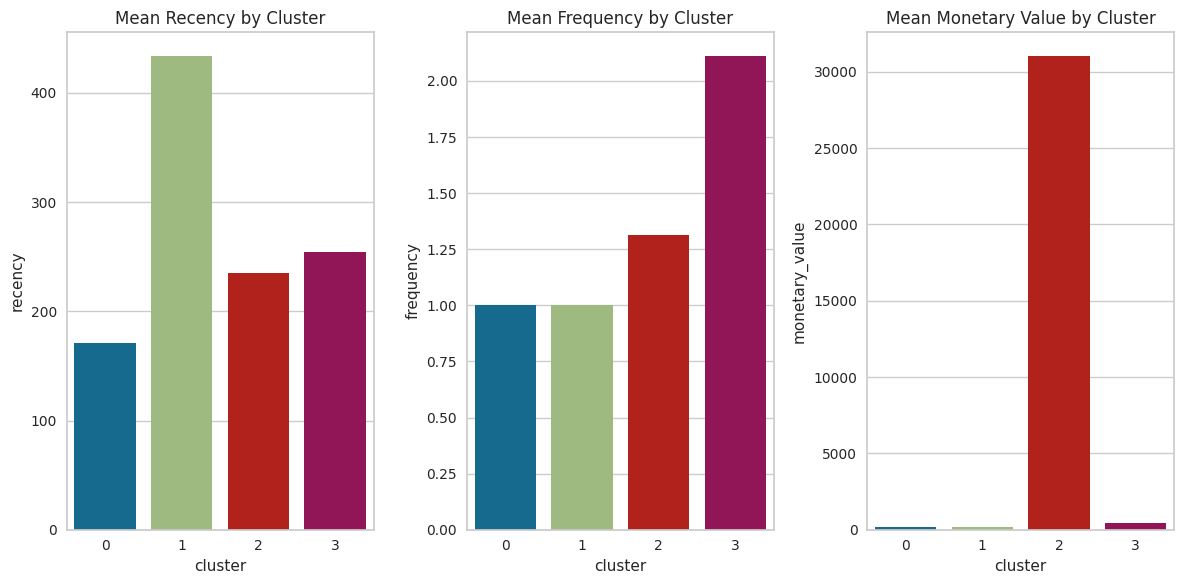

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'rfm_with_clusters' DataFrame

# Calculate the mean values of RFM features for each cluster
cluster_means = rfm_with_clusters.groupby('cluster')[['recency', 'frequency', 'monetary_value']].mean().reset_index()

# Plot the mean RFM values for each cluster
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='cluster', y='recency', data=cluster_means)
plt.title('Mean Recency by Cluster')

plt.subplot(1, 3, 2)
sns.barplot(x='cluster', y='frequency', data=cluster_means)
plt.title('Mean Frequency by Cluster')

plt.subplot(1, 3, 3)
sns.barplot(x='cluster', y='monetary_value', data=cluster_means)
plt.title('Mean Monetary Value by Cluster')

plt.tight_layout()
plt.show()

In [14]:
# Print the cluster sizes
cluster_sizes = rfm_with_clusters['cluster'].value_counts()
print('Cluster Sizes:')
print(cluster_sizes)

# Print a sample of customers from each cluster
print('\nSample Customers from Each Cluster:')
for cluster in cluster_sizes.index:
    sample_customers = rfm_with_clusters[rfm_with_clusters['cluster'] == cluster]['customer_unique_id'].sample(3)
    print(f'Cluster {cluster}:')
    print(sample_customers)
    print()

Cluster Sizes:
cluster
0    54575
1    34752
3     2738
2       16
Name: count, dtype: int64

Sample Customers from Each Cluster:
Cluster 0:
19401    35b7b2964b474b63fcd4346f63805bbb
26655    49edfe73ea287d715eebfced06b0bea9
73663    cc81b5498c0ab062c6a4d8464eb6e645
Name: customer_unique_id, dtype: object

Cluster 1:
52454    91fd427204396810b913b1faee9baa89
63111    af1edf385e7991560620a0f97fa3506e
57901    a0e39e460fe1aa52eb9affe3b7b4ff9f
Name: customer_unique_id, dtype: object

Cluster 3:
41536    7330a3475a2c65878c2c9b95266bef04
4700     0cf46588cd3f5a23002166b5a1945820
84272    ea09b32bf96ba057088e140c6bec60da
Name: customer_unique_id, dtype: object

Cluster 2:
11798    20a5257c01689ac69410a14cb51bb447
23097    4007669dec559734d6f53e029e360987
62669    adfa1cab2b2c8706db21bb13c0a1beb1
Name: customer_unique_id, dtype: object



In [15]:
cluster_means

,cluster,recency,frequency,monetary_value
0,0,170.599762,1.00000,199.867736
1,1,433.760273,1.00000,199.960282
2,2,235.250000,1.31250,31033.766875
3,3,254.353908,2.11103,429.934869


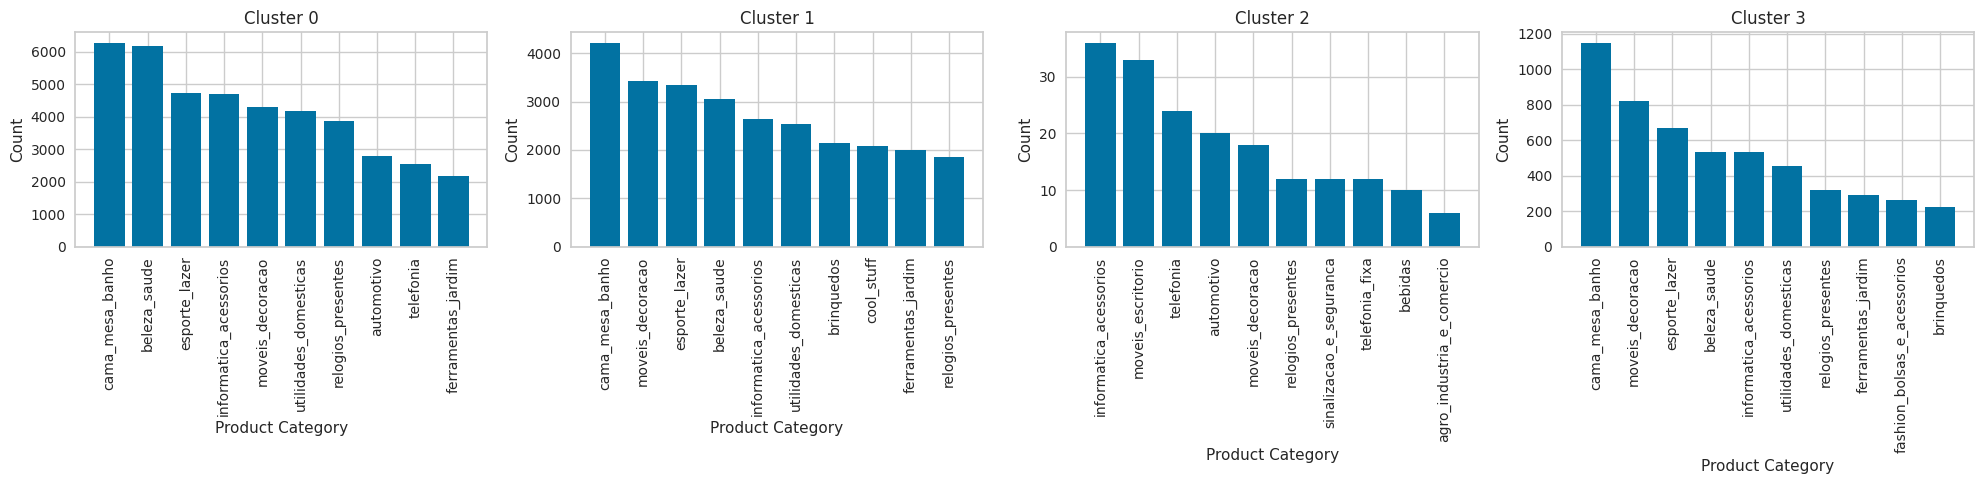

In [16]:
# Merge the cluster information with the main data
df = df.merge(rfm_with_clusters[['customer_unique_id', 'cluster']], on='customer_unique_id', how='left')

# Group by cluster and product_category_name, and count the occurrences
category_counts = df.groupby(['cluster', 'product_category_name']).size().reset_index(name='count')

# Plot bar charts for each cluster
fig, axs = plt.subplots(nrows=1, ncols=len(category_counts['cluster'].unique()), figsize=(20, 5))

for i, cluster in enumerate(category_counts['cluster'].unique()):
    cluster_data = category_counts[category_counts['cluster'] == cluster]
    top_10_categories = cluster_data.nlargest(10, 'count')
    axs[i].bar(top_10_categories['product_category_name'], top_10_categories['count'])
    axs[i].set_title(f'Cluster {cluster}')
    axs[i].set_xlabel('Product Category')
    axs[i].set_ylabel('Count')
    axs[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

> **don't need to read,can skip**

Cluster 0:
* **Home & Living**: cama_mesa_banho, casa_conforto, casa_construcao, construcao_ferramentas_construcao, construcao_ferramentas_ferramentas, construcao_ferramentas_iluminacao, construcao_ferramentas_jardim, construcao_ferramentas_seguranca, eletrodomesticos, eletrodomesticos_2, ferramentas_jardim, moveis_colchao_e_estofado, moveis_cozinha_area_de_servico_jantar_e_jardim, moveis_decoracao, moveis_escritorio, moveis_quarto, moveis_sala, portateis_casa_forno_e_cafe, portateis_cozinha_e_preparadores_de_alimentos, utilidades_domesticas.                                                       
* **Electronics & Accessories**: audio, cine_foto, climatizacao, consoles_games, cool_stuff, eletronicos, eletroportateis, informatica_acessorios, pc_gamer, pcs, tablets_impressao_imagem, telefonia, telefonia_fixa .
* **Fashion & Beauty**: beleza_saude, fashion_bolsas_e_acessorios, fashion_calcados, fashion_esporte, fashion_roupa_feminina, fashion_roupa_infanto_juvenil, fashion_roupa_masculina, fashion_underwear_e_moda_praia, perfumaria
* **Sports & Leisure**: esporte_lazer
* **Books & Media**: cds_dvds_musicais, dvds_blu_ray, livros_importados, livros_interesse_geral, livros_tecnicos, musica
* Other: agro_industria_e_comercio, alimentos, alimentos_bebidas, artes, artes_e_artesanato, artigos_de_festas, artigos_de_natal, automotivo, bebes, bebidas, brinquedos, flores, fraldas_higiene, industria_comercio_e_negocios, instrumentos_musicais, la_cuisine, malas_acessorios, market_place, papelaria, pet_shop, relogios_presentes, sinalizacao_e_seguranca

Cluster 1:

* Home & Living: cama_mesa_banho, casa_conforto, casa_conforto_2, casa_construcao, construcao_ferramentas_construcao, construcao_ferramentas_ferramentas, construcao_ferramentas_iluminacao, construcao_ferramentas_jardim, construcao_ferramentas_seguranca, eletrodomesticos, eletrodomesticos_2, ferramentas_jardim, moveis_colchao_e_estofado, moveis_cozinha_area_de_servico_jantar_e_jardim, moveis_decoracao, moveis_escritorio, moveis_quarto, moveis_sala, portateis_casa_forno_e_cafe, utilidades_domesticas
* Electronics & Accessories: audio, cine_foto, climatizacao, consoles_games, cool_stuff, eletronicos, eletroportateis, informatica_acessorios, pc_gamer, pcs, tablets_impressao_imagem, telefonia, telefonia_fixa
* Fashion & Beauty: beleza_saude, fashion_bolsas_e_acessorios, fashion_calcados, fashion_esporte, fashion_roupa_feminina, fashion_roupa_infanto_juvenil, fashion_roupa_masculina, fashion_underwear_e_moda_praia, perfumaria
* Sports & Leisure: esporte_lazer
* Books & Media: cds_dvds_musicais, dvds_blu_ray, livros_importados, livros_interesse_geral, livros_tecnicos, musica
* Other: agro_industria_e_comercio, alimentos, alimentos_bebidas, artes, artes_e_artesanato, artigos_de_festas, artigos_de_natal, automotivo, bebes, bebidas, brinquedos, flores, fraldas_higiene, industria_comercio_e_negocios, instrumentos_musicais, la_cuisine, malas_acessorios, market_place, papelaria, pet_shop, relogios_presentes, seguros_e_servicos, sinalizacao_e_seguranca

Cluster 2:

* Electronics & Accessories: informatica_acessorios, telefonia, telefonia_fixa
* Home & Living: moveis_decoracao, moveis_escritorio
* Other: agro_industria_e_comercio, automotivo, bebidas, relogios_presentes, sinalizacao_e_seguranca

Cluster 3:
* Home & Living: cama_mesa_banho, casa_conforto, casa_conforto_2, casa_construcao, construcao_ferramentas_construcao, construcao_ferramentas_ferramentas, construcao_ferramentas_iluminacao, construcao_ferramentas_jardim, construcao_ferramentas_seguranca, eletrodomesticos, eletrodomesticos_2, ferramentas_jardim, moveis_colchao_e_estofado, moveis_cozinha_area_de_servico_jantar_e_jardim, moveis_decoracao, moveis_escritorio, moveis_quarto, moveis_sala, portateis_casa_forno_e_cafe, utilidades_domesticas
* Electronics & Accessories: audio, cine_foto, climatizacao, consoles_games, eletronicos, eletroportateis, informatica_acessorios, tablets_impressao_imagem, telefonia, telefonia_fixa
* Fashion & Beauty: beleza_saude, fashion_bolsas_e_acessorios, fashion_calcados, fashion_esporte, fashion_roupa_feminina, fashion_roupa_infanto_juvenil, fashion_roupa_masculina, fashion_underwear_e_moda_praia, perfumaria
* Sports & Leisure: esporte_lazer
* Books & Media: dvds_blu_ray, livros_importados, livros_interesse_geral, livros_tecnicos, musica
* Other: agro_industria_e_comercio, alimentos, alimentos_bebidas, artes, artes_e_artesanato, artigos_de_festas, artigos_de_natal, automotivo, bebes, bebidas, brinquedos, fraldas_higiene, industria_comercio_e_negocios, instrumentos_musicais, la_cuisine, malas_acessorios, market_place, papelaria, pc_gamer, pcs, pet_shop, relogios_presentes, sinalizacao_e_seguranca

In [17]:
category_counts

,cluster,product_category_name,count
0,0,agro_industria_e_comercio,194
1,0,alimentos,374
2,0,alimentos_bebidas,154
3,0,artes,169
4,0,artes_e_artesanato,18
...,...,...,...
218,3,sinalizacao_e_seguranca,11
219,3,tablets_impressao_imagem,4
220,3,telefonia,205
221,3,telefonia_fixa,11


> **summary rfm**

Cluster 0:

This cluster has a high concentration of products related to home and living, including furniture, home appliances, home construction and tools, gardening, and household utilities.
Books & Media: There is a moderate presence of products in the books and media category, such as CDs, DVDs, books (imported, general interest, and technical), and music.
Cluster Mean Values: recency = 170.6, frequency = 1.0, monetary_value = 199.87
This cluster has a relatively low recency value (indicating more recent purchases), low frequency, and a moderate monetary value.

Cluster 1:

Similar to Cluster 0, this cluster also has a strong representation of home and living products across various subcategories.
Books & Media: The presence of books and media products is comparable to Cluster 0.
Cluster Mean Values: recency = 433.76, frequency = 1.0, monetary_value = 199.96
This cluster has a higher recency value (indicating less recent purchases), low frequency, and a monetary value similar to Cluster 0.

Cluster 2:

This cluster has a lower concentration of home and living products, with a focus on furniture and home decor.
Books & Media: There is no significant presence of books and media products in this cluster.
Cluster Mean Values: recency = 235.25, frequency = 1.3125, monetary_value = 31033.77
This cluster has a moderate recency value, slightly higher frequency, and a remarkably high monetary value compared to the other clusters.

Cluster 3:

Similar to Clusters 0 and 1, this cluster has a good representation of home and living products across various subcategories.
Books & Media: There is a lower presence of books and media products compared to Clusters 0 and 1.
Cluster Mean Values: recency = 254.35, frequency = 2.11, monetary_value = 429.93
This cluster has a moderate recency value, higher frequency, and a higher monetary value compared to Clusters 0 and 1, but significantly lower than Cluster 2.

In [18]:
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
dftime=df
dftime['order_date'] = dftime['order_delivered_customer_date'].dt.date
df['order_delivered_customer_date']

0        2017-10-10 21:25:13
1        2017-10-10 21:25:13
2        2017-10-10 21:25:13
3        2018-08-07 15:27:45
4        2018-08-17 18:06:29
                 ...        
113385   2018-02-28 17:37:56
113386   2017-09-21 11:24:17
113387   2018-01-25 23:32:54
113388   2018-01-25 23:32:54
113389   2018-03-16 13:08:30
Name: order_delivered_customer_date, Length: 113390, dtype: datetime64[ns]

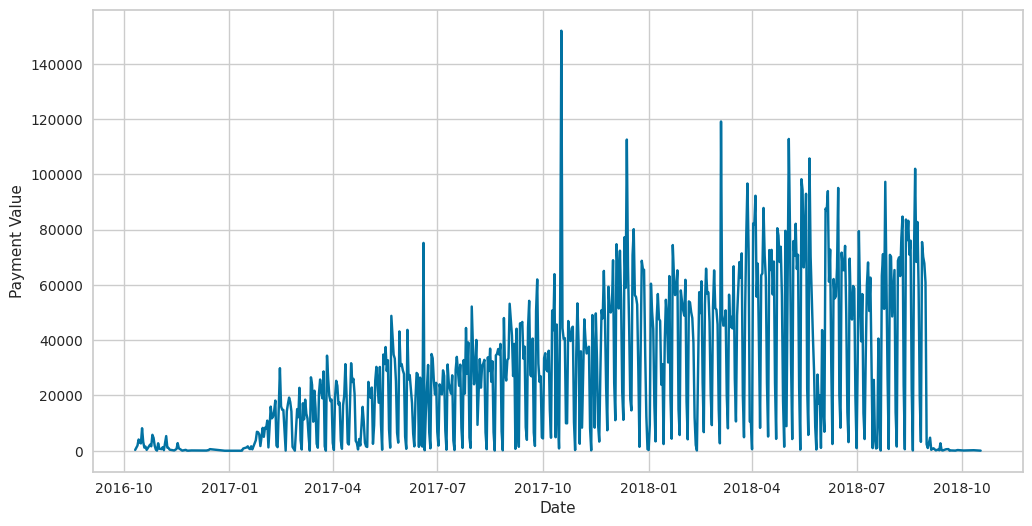

In [19]:
daily_payment_values = dftime.groupby('order_date')['payment_value'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_payment_values['order_date'], daily_payment_values['payment_value'])
plt.xlabel('Date')
plt.ylabel('Payment Value')
plt.show()

In [20]:
daily_payment_values['order_date'] = pd.to_datetime(daily_payment_values['order_date'])

# Set 'date' as the index
daily_payment_values.set_index('order_date', inplace=True)

In [21]:
daily_payment_values

,payment_value
order_date,
2016-10-11,314.39
2016-10-13,1887.71
2016-10-14,4090.33
2016-10-15,3041.21
2016-10-16,2657.34
...,...
2018-09-25,65.35
2018-09-27,265.94
2018-10-02,101.36


In [22]:
y = daily_payment_values.squeeze()
y_weekly = y.resample('W').sum()
y_weekly = y_weekly.dropna()

In [23]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(y):
    if y.nunique() <= 1:  # check if time series is constant
        return False
    result = adfuller(y)
    return result[1] <= 0.05  # p-value is less than 0.05

# Assuming y_weekly is sorted in descending order of date
for start in range(0, len(y_weekly)):
    if check_stationarity(y_weekly.iloc[start:]):
        break

stationary_y_weekly = y_weekly.iloc[start:]
print(stationary_y_weekly)

order_date
2016-12-04     196.16
2016-12-11       0.00
2016-12-18     941.23
2016-12-25       0.00
2017-01-01      19.62
               ...   
2018-09-23    1341.22
2018-09-30     331.29
2018-10-07     101.36
2018-10-14     201.96
2018-10-21      44.63
Freq: W-SUN, Name: payment_value, Length: 99, dtype: float64


In [24]:
y_weekly = y_weekly.loc['2016-12-04':'2018-10-21']
y_weekly

order_date
2016-12-04     196.16
2016-12-11       0.00
2016-12-18     941.23
2016-12-25       0.00
2017-01-01      19.62
               ...   
2018-09-23    1341.22
2018-09-30     331.29
2018-10-07     101.36
2018-10-14     201.96
2018-10-21      44.63
Freq: W-SUN, Name: payment_value, Length: 99, dtype: float64

In [25]:


result = adfuller(y_weekly.values.flatten())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.896728
p-value: 0.045730


In [26]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:00


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt

In [28]:
model = auto_arima(y_weekly,d=0,  suppress_warnings=True)

In [29]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1246.110
Date:                Tue, 07 May 2024   AIC                           2500.221
Time:                        11:12:20   BIC                           2510.601
Sample:                    12-04-2016   HQIC                          2504.421
                         - 10-21-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.743e+04   1.73e+04      1.584      0.113   -6515.087    6.14e+04
ar.L1          0.6952      0.078      8.927      0.000       0.543       0.848
ar.L2          0.1575      0.072      2.201      0.0

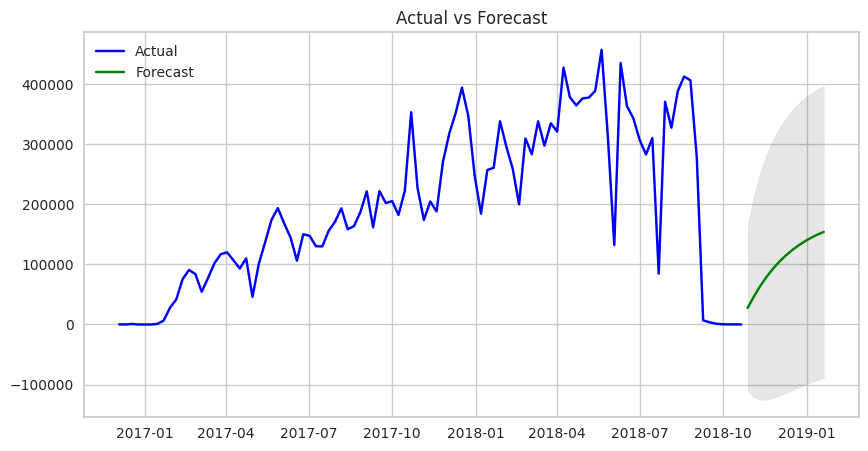

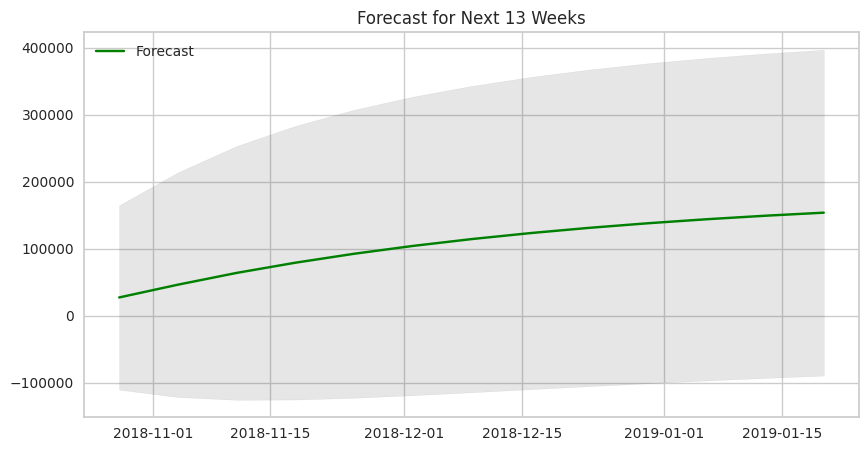

In [30]:
# Make predictions for the next 13 weeks
forecast, conf_int = model.predict(n_periods=13, return_conf_int=True)

# Create a pandas series with the forecast and conf_int
forecast_index = pd.date_range(start=y_weekly.index[-1] + pd.Timedelta(days=7), periods=13, freq='W')
forecast_series = pd.Series(forecast, index=forecast_index)
lower_series = pd.Series(conf_int[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int[:, 1], index=forecast_index)

# Plot the actual data
plt.figure(figsize=(10, 5))
plt.plot(y_weekly.index, y_weekly, label='Actual', color='blue')

# Plot the forecast along with the confidence interval
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)

plt.title('Actual vs Forecast')
plt.legend(loc='upper left')
plt.show()

# Plot the forecast only
plt.figure(figsize=(10, 5))
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)

plt.title('Forecast for Next 13 Weeks')
plt.legend(loc='upper left')
plt.show()

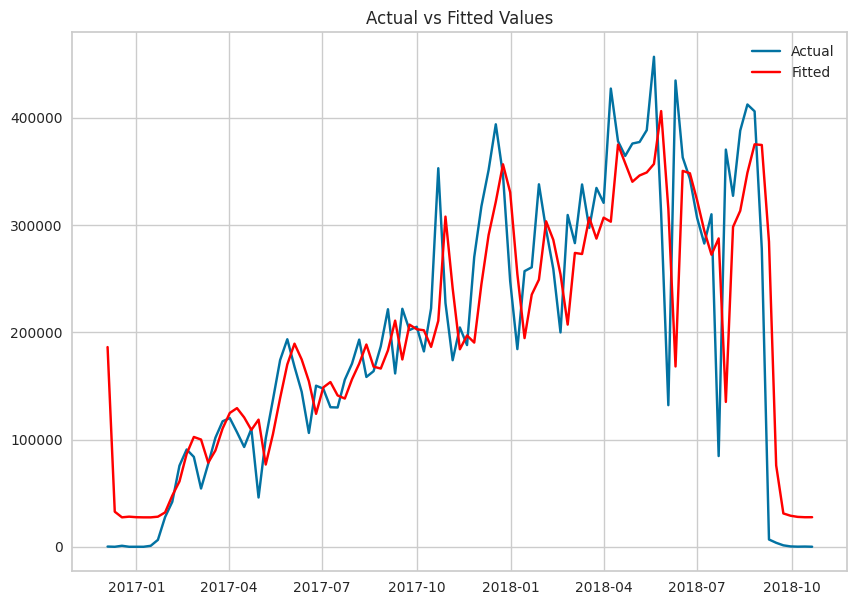

In [31]:
# Fit the model
model = auto_arima(y_weekly, d=0, suppress_warnings=True)

# Get the fitted values
fitted_values = model.predict_in_sample()

# Create a plot
plt.figure(figsize=(10,7))
plt.plot(y_weekly, label='Actual')
plt.plot(fitted_values, color='red', label='Fitted')
plt.title('Actual vs Fitted Values')
plt.legend()
plt.show()

In [32]:
y_weekly

order_date
2016-12-04     196.16
2016-12-11       0.00
2016-12-18     941.23
2016-12-25       0.00
2017-01-01      19.62
               ...   
2018-09-23    1341.22
2018-09-30     331.29
2018-10-07     101.36
2018-10-14     201.96
2018-10-21      44.63
Freq: W-SUN, Name: payment_value, Length: 99, dtype: float64

In [33]:
forecast_series

2018-10-28     27494.626996
2018-11-04     46553.804854
2018-11-11     64127.427791
2018-11-18     79346.758378
2018-11-25     92695.358740
2018-12-02    104372.593813
2018-12-09    114593.224991
2018-12-16    123537.958609
2018-12-23    131366.249865
2018-12-30    138217.416176
2019-01-06    144213.427745
2019-01-13    149461.022970
2019-01-20    154053.618640
Freq: W-SUN, dtype: float64

In [34]:

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import normaltest


In [35]:

# Get the residuals
residuals = model.resid()

result = adfuller(residuals)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Check if stationary
if result[1] <= 0.05:
    print("The series is stationary")
else:
    print("The series is not stationary")

ADF Statistic: -10.086144
p-value: 0.000000
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583
The series is stationary


Text(0.5, 1.0, 'Autocorrelation Plot')

<Figure size 1000x400 with 0 Axes>

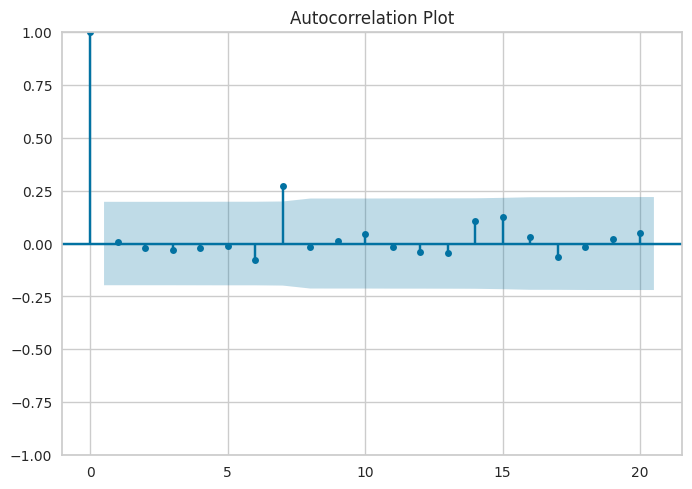

In [36]:
# 2. Check Independence of Errors
plt.figure(figsize=(10,4))
_ = plot_acf(residuals, lags=20)
plt.title('Autocorrelation Plot')

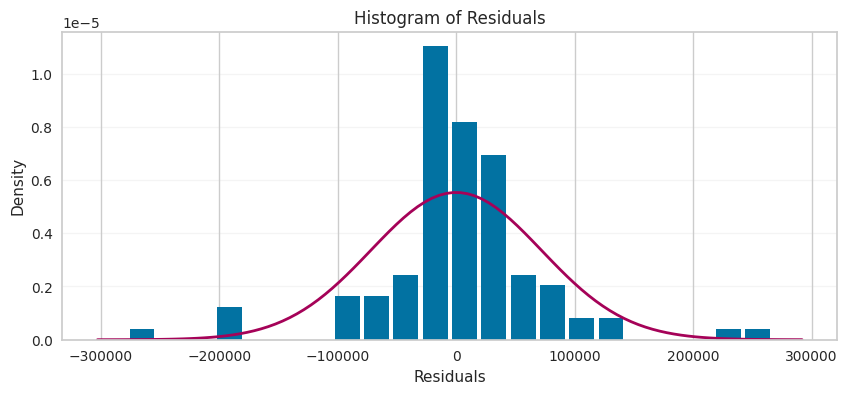

Results of Kolmogorov-Smirnov Test:
Statistic=16.924, p=0.000


In [37]:
from scipy.stats import norm
# 3. Check Normality of Errors
plt.figure(figsize=(10,4))
plt.hist(residuals, bins='auto', density=True, rwidth=0.85,
         label='Residuals')
mu, std = norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'm', linewidth=2)
plt.grid(axis='y', alpha=0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Histogram of Residuals')
plt.show()

# Perform the Kolmogorov-Smirnov test for normality
print('Results of Kolmogorov-Smirnov Test:')
kstest = normaltest(residuals)
print('Statistic=%.3f, p=%.3f' % (kstest.statistic, kstest.pvalue))